### mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/JnQ/'

os.chdir(current_path)

Mounted at /content/drive


### requirements

In [4]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from funcs_indicator import *
# import matplotlib.pyplot as plt

# import mpl_finance as mf
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### load data

In [20]:
os.chdir(current_path)


interval = '30m'
interval = '5m'
interval = '1m'

date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
# date_path = './candlestick_concated/%s/2021-06-14/' % interval
date_path = './candlestick_concated/%s/eth_set/' % interval
file_list = os.listdir(date_path)

print(sorted(file_list))

['2020-04-22 ETHUSDT.xlsx', '2020-05-22 ETHUSDT.xlsx', '2020-06-21 ETHUSDT.xlsx', '2020-07-21 ETHUSDT.xlsx', '2020-08-20 ETHUSDT.xlsx', '2020-09-19 ETHUSDT.xlsx', '2020-10-19 ETHUSDT.xlsx', '2020-11-18 ETHUSDT.xlsx', '2020-12-18 ETHUSDT.xlsx', '2021-01-17 ETHUSDT.xlsx', '2021-02-16 ETHUSDT.xlsx', '2021-03-18 ETHUSDT.xlsx', '2021-04-17 ETHUSDT.xlsx', '2021-05-17 ETHUSDT.xlsx']


### windowing + retrain

#### window settings

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

# np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

window_size = 30
input_size = 15
label_size = 15

target = "pr"

start_stamp : 0


#### make datasets

In [13]:
data_x, data_labels = [], []
data_x_labels = []

fee = 0.0006

# close_x, label_close_x = [], []
# data_index = []

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  # if 'neo'.upper() not in candis[i]:
    # continue
  
  # if 'btc'.upper() not in candis[i]:
  #   continue

  if 'eth'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))
    df = ohlcv

    # df['pr'] = df['close'].pct_change()

    #   진입 구간과 이탈 구간에서 발생하는 pr 만들기    #

    # df['pr'] = df['close'].shift(-(label_size - 1)) / df['close']

    #         post fee adjustment       #
    # df['pr'] = df['close'].shift(-(label_size - 1)) / df['close'] - fee
    df['pr'] = df['close'].shift(-label_size) / df['close'] - fee

    # print(df['close'].head(20))
    # print(df['close'].shift(-14).head(20))
    # break

    # sar = lucid_sar(ohlcv)
    # ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
    # ema1, ema2, ema3 = ema_ribbon(ohlcv)
    # senkou1, senkou2 = ichimoku(ohlcv)
    # cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

    # _, _, bbw = bb_width(ohlcv, 20, 2) 

    df['fish60'] = fisher(ohlcv, 60)
    df['trix'] = trix_hist(ohlcv, 14, 1, 5) 
    # rsi_ = rsi(ohlcv)
    df['macd_hist'] = macd(ohlcv)

    # print(df.describe().transpose())
    # print(df.head())

    # print((np.isnan(df.values)))
    print("np.sum(np.isnan(df.values), axis=0) :", np.sum(np.isnan(df.values), axis=0))

    max_nan = np.max(np.sum(np.isnan(df.values), axis=0))
    # print(max_nan)

    df = df.iloc[max_nan:-max_nan]

    print("df.describe().transpose() :", df.describe().transpose())


    column_indices = {name: i for i, name in enumerate(df.columns)}
    num_features = df.shape[1]
    print("num_features :", num_features)
    print("column_indices :", column_indices)
    
    target_label_index = column_indices[target]

    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
    min_max = MinMaxScaler()
    std_scale = StandardScaler()

    def min_max_scale(npy_x):

      return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


    #       local scaling     #
    # shift_size = window_size
    shift_size = label_size
    # shift_size = 1

    for i in range(input_size, len(df), shift_size):
        
        # temp_data = df.values[i - input_size:i]
        # temp_labels = df.values[i:i + label_size]

        # scaled_data = min_max_scale(df.values[i - input_size:i + label_size])
        # scaled_data = min_max.fit_transform(df.values[i - input_size:i + label_size])
        # temp_data = scaled_data[:input_size]
        # temp_labels = scaled_data[input_size:]

        #     ohlc    #
        temp_data = min_max_scale(df.values[i - input_size:i, :4])
        
        prev_data = df.values[i - input_size:i, :4]
        label_data = df.values[i: i + label_size, :4]
        temp_x_labels = (label_data - np.min(prev_data)) / (np.max(prev_data) - np.min(prev_data))

        temp_labels = df.values[i, target_label_index]

        # temp_data = std_scale.fit_transform(df.values[i - input_size:i])
        # # temp_labels = std_scale.transform(df.values[i:i + label_size])
        # temp_labels = df.values[i + shift - input_size:i + shift]

        # print(df.index[i - input_size:i][-1])
        # print(df.index[i:i + label_size][0])
        # print()

        if np.isnan(np.sum(temp_data)) or np.isnan(np.sum(temp_x_labels)):
          continue

        if len(temp_x_labels) < label_size:
          continue

        data_x.append(temp_data)
        data_x_labels.append(temp_x_labels)
        data_labels.append(temp_labels)
        # close_x.append(df.values[i - input_size:i, [3]])
        # label_close_x.append(df.values[i:i + label_size, [3]])


data_x = np.array(data_x).astype(np.float32)
data_x_labels = np.array(data_x_labels).astype(np.float32)
data_labels = np.array(data_labels).astype(np.float32)

# print(len(df) - total_window_size)
print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

print("data_x.dtype :", data_x.dtype)
print("data_labels.dtype :", data_labels.dtype)

len(ohlcv) : 43200
np.sum(np.isnan(df.values), axis=0) : [ 0  0  0  0  0 15 59  5 24]
df.describe().transpose() :              count        mean          std         min         25%         50%         75%           max
open       43082.0  234.438948     6.599993  216.100000  228.590000  234.800000  239.570000    249.290000
high       43082.0  234.519628     6.602329  217.140000  228.690000  234.860000  239.650000    249.410000
low        43082.0  234.357984     6.597583  213.590000  228.510000  234.730000  239.500000    249.040000
close      43082.0  234.439462     6.599813  216.010000  228.590000  234.800000  239.570000    249.300000
volume     43082.0  669.324691  1534.299611    0.212000  119.341000  293.009500  682.371750  59324.277000
pr         43082.0    0.999422     0.002289    0.960983    0.998320    0.999442    1.000556      1.016357
fish60     43082.0    0.087344     1.852838   -7.594532   -1.198235    0.083114    1.348062      7.588777
trix       43082.0   -0.000001     0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide



data_x.shape : (40191, 15, 4)
data_x_labels.shape : (40191, 15, 4)
data_labels.shape : (40191,)
data_x.dtype : float32
data_labels.dtype : float32


#### save dataset

In [15]:
pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_prefee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_prefee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_prefee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

np.save(x_save_path, data_x)
np.save(x_label_save_path, data_x_labels)
np.save(label_save_path, data_labels)


#### load dataset

In [7]:
key = "dates ETHUSDT.xlsx"
len_data_x = 20104

shift_size = 30

pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)

data_x = np.load(x_save_path)
data_x_labels = np.load(x_label_save_path)
data_labels = np.load(label_save_path)

print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

data_x.shape : (20104, 15, 10)
data_x_labels.shape : (20104, 15, 10)
data_labels.shape : (20104,)


### single step models

In [16]:
MAX_EPOCHS = 100
# MAX_EPOCHS = 1000
# MAX_EPOCHS = 500

patience = MAX_EPOCHS // 5
# patience = 2

ckpt_path = current_path + 'ckpt/'

def compile_and_fit(model, model_name, train_flow, val_flow, class_weight=None, patience=patience):

  tf.keras.backend.clear_session()

  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

  # model.compile(loss='categorical_crossentropy', 
  #               optimizer=tf.optimizers.Adam(learning_rate=1e-5, decay=5e-6), 
  #               # optimizer=tf.optimizers.Adam(learning_rate=1e-6, decay=5e-7), 
  #               metrics=['accuracy'])
  
  # model.compile(loss='categorical_crossentropy', 
  # model.compile(loss=tf.losses.SparseCategoricalCrossentropy(), 
  #               optimizer=tf.optimizers.Adam(learning_rate=1e-3, decay=1e-4),
  #               metrics=[tf.metrics.Accuracy()])

  model.compile(loss=tf.losses.MeanSquaredError(),
                # optimizer=tf.optimizers.Adam(learning_rate=1e-4, decay=1e-5),
                optimizer=tf.optimizers.Adam(learning_rate=1e-5, decay=5e-6), 
                # optimizer=tf.optimizers.Adam(learning_rate=1e-3, decay=1e-4),
                metrics=[tf.metrics.MeanAbsoluteError()])
  

  history = model.fit(train_flow, epochs=MAX_EPOCHS,
                      validation_data=val_flow,
                      callbacks=[checkpoint, early_stopping],
                      # callbacks=[early_stopping],
                      # class_weight=class_weight
                      )
  return history

#### models

#### cnn 2d

In [17]:
# cnn2d_model = tf.keras.Sequential([
                                 
#       # Shape => [batch, 1, conv_units]
#       # tf.keras.layers.Input(shape=)
#       tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3),
      
#       tf.keras.layers.Flatten(),
#       tf.keras.layers.Dense(128, activation='relu'),
#       tf.keras.layers.Dense(64, activation='relu'),

#       tf.keras.layers.Dense(2, activation="softmax")
# ])


def cnn2d_model(input_shape):

    visible = tf.keras.layers.Input(shape=input_shape, name='input')
    
    net = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.BatchNormalization()(net)
    # net = tf.keras.layers.Activation('relu')(net)
    net = tf.keras.layers.LeakyReLU()(net)
    # net = tf.keras.layers.MaxPool2D(pool_size=2)(net)
    # net = tf.keras.layers.AveragePooling2D(padding='same')(net)


    # net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.BatchNormalization()(net)
    # net = tf.keras.layers.Activation('relu')(net)
    net = tf.keras.layers.LeakyReLU()(net)
    # net = tf.keras.layers.MaxPool2D(pool_size=2)(net)

    net = tf.keras.layers.Flatten()(net)
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Dense(64)(net)
    net = tf.keras.layers.LeakyReLU()(net)

    # net = tf.keras.layers.Dense(2, activation='softmax')(net)
    net = tf.keras.layers.Dense(1)(net)

    # create model 
    model = tf.keras.models.Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

##### lstm

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(1)
])


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.3),
    # Shape => [batch, time, features]
    
    tf.keras.layers.Dense(units=1)
])


##### cnn

In [ ]:
CONV_WIDTH = 3

cnn_model = tf.keras.Sequential([
                                 
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
      # tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(3)),

      tf.keras.layers.Dense(64, activation='relu'),

      tf.keras.layers.Dense(1)
])

#### test_bed

last_index : 10000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 12ms/step - loss: 0.1026 - mean_absolute_error: 0.2225 - val_loss: 0.0145 - val_mean_absolute_error: 0.0964

Epoch 00001: val_loss improved from inf to 0.01452, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_10000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0147 - mean_absolute_error: 0.0945 - val_loss: 0.0103 - val_mean_absolute_error: 0.0803

Epoch 00002: val_loss improved from 0.01452 to 0.01032, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_10000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0115 - mean_absolute_error: 0.0832 - val_loss: 0.0089 - val_mean_absolute_error: 0.0741

E

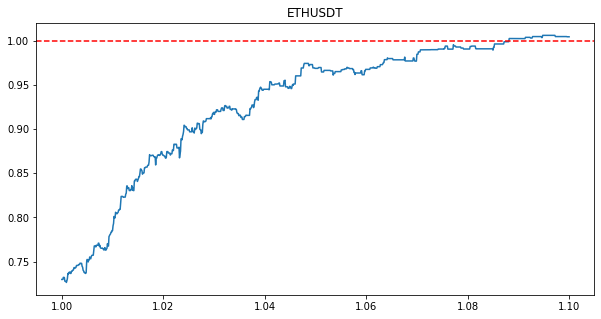

last_index : 11000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0729 - mean_absolute_error: 0.1949 - val_loss: 0.0173 - val_mean_absolute_error: 0.1045

Epoch 00001: val_loss improved from inf to 0.01728, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_11000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0144 - mean_absolute_error: 0.0935 - val_loss: 0.0104 - val_mean_absolute_error: 0.0798

Epoch 00002: val_loss improved from 0.01728 to 0.01040, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_11000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0099 - mean_absolute_error: 0.0767 - val_loss: 0.0084 - val_mean_absolute_error: 0.0711

Ep

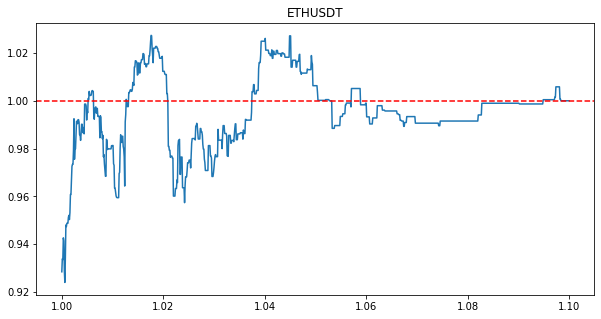

last_index : 12000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0574 - mean_absolute_error: 0.1763 - val_loss: 0.0198 - val_mean_absolute_error: 0.1108

Epoch 00001: val_loss improved from inf to 0.01981, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_12000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0131 - mean_absolute_error: 0.0884 - val_loss: 0.0125 - val_mean_absolute_error: 0.0864

Epoch 00002: val_loss improved from 0.01981 to 0.01247, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_12000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0100 - mean_absolute_error: 0.0774 - val_loss: 0.0099 - val_mean_absolute_error: 0.0765

Ep

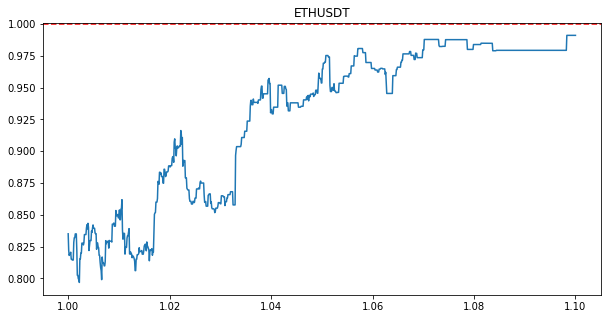

last_index : 13000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0493 - mean_absolute_error: 0.1580 - val_loss: 0.0131 - val_mean_absolute_error: 0.0904

Epoch 00001: val_loss improved from inf to 0.01312, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_13000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0773 - val_loss: 0.0090 - val_mean_absolute_error: 0.0723

Epoch 00002: val_loss improved from 0.01312 to 0.00897, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_13000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_absolute_error: 0.0681 - val_loss: 0.0077 - val_mean_absolute_error: 0.0664

Ep

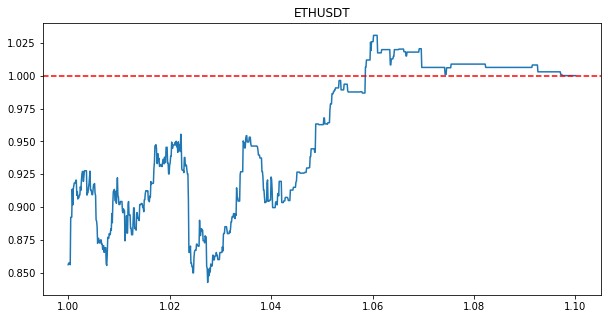

last_index : 14000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.1516 - mean_absolute_error: 0.2617 - val_loss: 0.0209 - val_mean_absolute_error: 0.1156

Epoch 00001: val_loss improved from inf to 0.02089, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_14000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0158 - mean_absolute_error: 0.0995 - val_loss: 0.0141 - val_mean_absolute_error: 0.0937

Epoch 00002: val_loss improved from 0.02089 to 0.01407, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_14000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0125 - mean_absolute_error: 0.0883 - val_loss: 0.0115 - val_mean_absolute_error: 0.0850

Ep

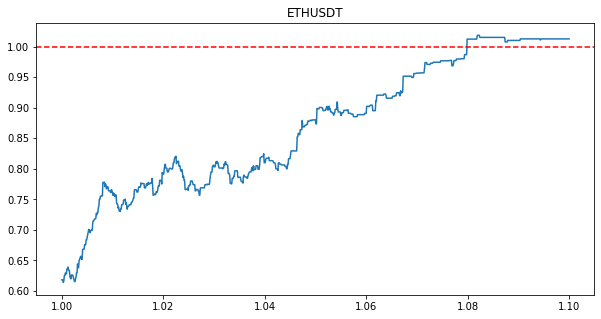

last_index : 15000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0878 - mean_absolute_error: 0.2050 - val_loss: 0.0161 - val_mean_absolute_error: 0.1002

Epoch 00001: val_loss improved from inf to 0.01615, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_15000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0128 - mean_absolute_error: 0.0887 - val_loss: 0.0110 - val_mean_absolute_error: 0.0824

Epoch 00002: val_loss improved from 0.01615 to 0.01100, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_15000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0760 - val_loss: 0.0089 - val_mean_absolute_error: 0.0736

Ep

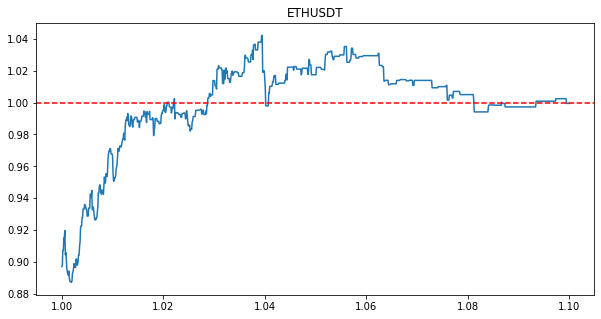

last_index : 16000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0331 - mean_absolute_error: 0.1386 - val_loss: 0.0136 - val_mean_absolute_error: 0.0913

Epoch 00001: val_loss improved from inf to 0.01356, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_16000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0111 - mean_absolute_error: 0.0820 - val_loss: 0.0094 - val_mean_absolute_error: 0.0749

Epoch 00002: val_loss improved from 0.01356 to 0.00940, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_16000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_absolute_error: 0.0698 - val_loss: 0.0078 - val_mean_absolute_error: 0.0685

Ep

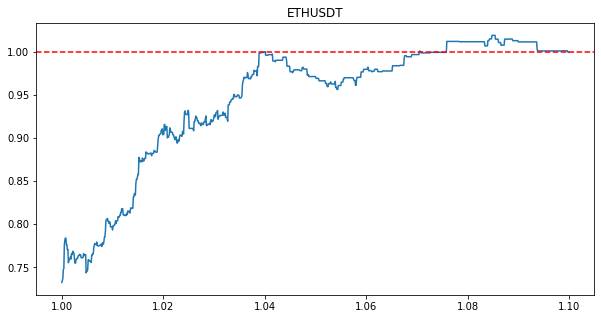

last_index : 17000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0344 - mean_absolute_error: 0.1378 - val_loss: 0.0122 - val_mean_absolute_error: 0.0867

Epoch 00001: val_loss improved from inf to 0.01222, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_17000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0099 - mean_absolute_error: 0.0767 - val_loss: 0.0091 - val_mean_absolute_error: 0.0741

Epoch 00002: val_loss improved from 0.01222 to 0.00914, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_17000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0683 - val_loss: 0.0092 - val_mean_absolute_error: 0.0742

Ep

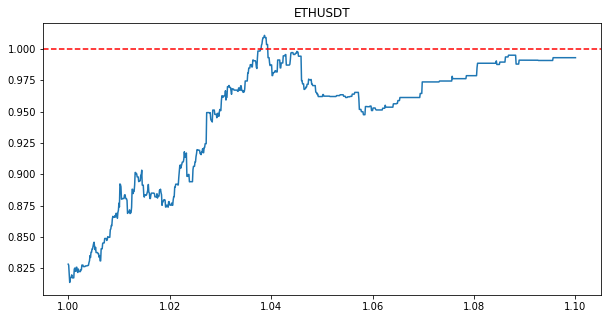

last_index : 18000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.3482 - mean_absolute_error: 0.3755 - val_loss: 0.0255 - val_mean_absolute_error: 0.1273

Epoch 00001: val_loss improved from inf to 0.02555, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_18000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0203 - mean_absolute_error: 0.1126 - val_loss: 0.0159 - val_mean_absolute_error: 0.1000

Epoch 00002: val_loss improved from 0.02555 to 0.01587, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_18000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0922 - val_loss: 0.0118 - val_mean_absolute_error: 0.0852

Ep

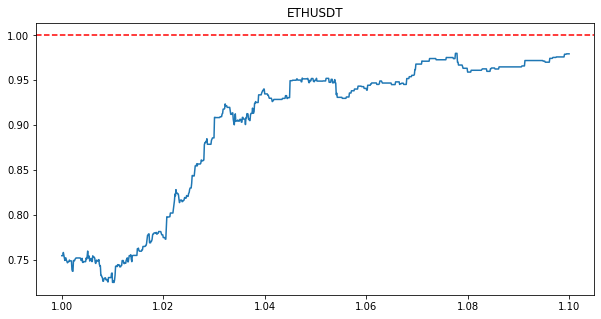

last_index : 19000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0363 - mean_absolute_error: 0.1404 - val_loss: 0.0140 - val_mean_absolute_error: 0.0913

Epoch 00001: val_loss improved from inf to 0.01401, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_19000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0783 - val_loss: 0.0101 - val_mean_absolute_error: 0.0774

Epoch 00002: val_loss improved from 0.01401 to 0.01008, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_19000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0075 - mean_absolute_error: 0.0665 - val_loss: 0.0081 - val_mean_absolute_error: 0.0686

Ep

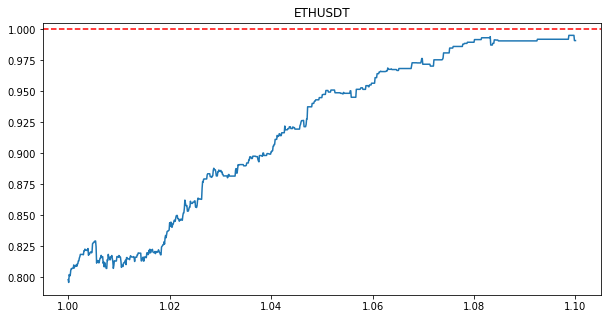

last_index : 20000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0935 - mean_absolute_error: 0.2192 - val_loss: 0.0262 - val_mean_absolute_error: 0.1264

Epoch 00001: val_loss improved from inf to 0.02616, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_20000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0159 - mean_absolute_error: 0.0999 - val_loss: 0.0155 - val_mean_absolute_error: 0.0954

Epoch 00002: val_loss improved from 0.02616 to 0.01554, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_20000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0794 - val_loss: 0.0122 - val_mean_absolute_error: 0.0841

Ep

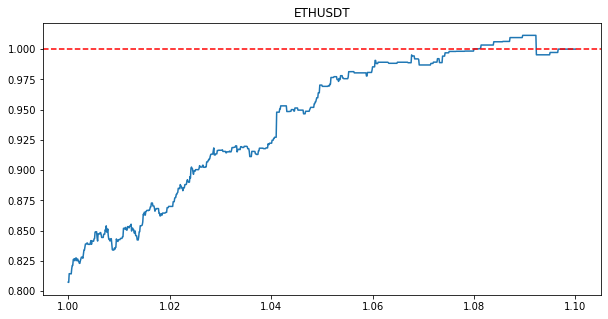

last_index : 21000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.1297 - mean_absolute_error: 0.2516 - val_loss: 0.0265 - val_mean_absolute_error: 0.1288

Epoch 00001: val_loss improved from inf to 0.02650, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_21000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0179 - mean_absolute_error: 0.1062 - val_loss: 0.0194 - val_mean_absolute_error: 0.1088

Epoch 00002: val_loss improved from 0.02650 to 0.01937, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_21000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0133 - mean_absolute_error: 0.0905 - val_loss: 0.0153 - val_mean_absolute_error: 0.0955

Ep

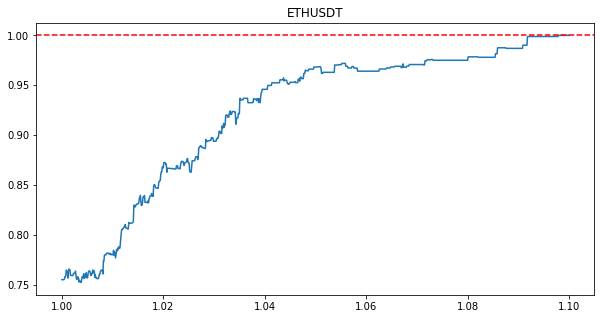

last_index : 22000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0863 - mean_absolute_error: 0.2056 - val_loss: 0.0206 - val_mean_absolute_error: 0.1110

Epoch 00001: val_loss improved from inf to 0.02058, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_22000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0149 - mean_absolute_error: 0.0963 - val_loss: 0.0147 - val_mean_absolute_error: 0.0930

Epoch 00002: val_loss improved from 0.02058 to 0.01465, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_22000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0835 - val_loss: 0.0114 - val_mean_absolute_error: 0.0811

Ep

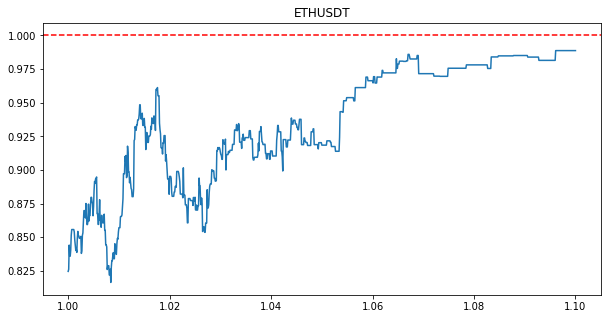

last_index : 23000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0378 - mean_absolute_error: 0.1441 - val_loss: 0.0128 - val_mean_absolute_error: 0.0862

Epoch 00001: val_loss improved from inf to 0.01278, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_23000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0112 - mean_absolute_error: 0.0817 - val_loss: 0.0091 - val_mean_absolute_error: 0.0732

Epoch 00002: val_loss improved from 0.01278 to 0.00915, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_23000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0710 - val_loss: 0.0073 - val_mean_absolute_error: 0.0658

Ep

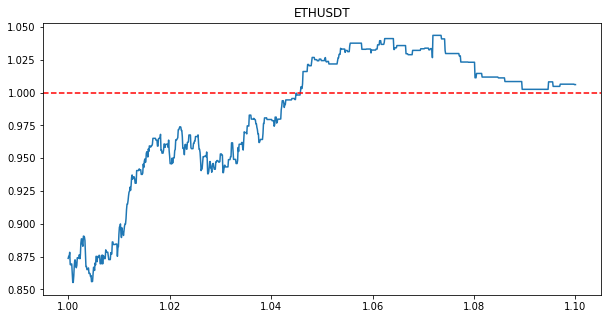

last_index : 24000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.1369 - mean_absolute_error: 0.2571 - val_loss: 0.0199 - val_mean_absolute_error: 0.1105

Epoch 00001: val_loss improved from inf to 0.01993, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_24000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0167 - mean_absolute_error: 0.1009 - val_loss: 0.0135 - val_mean_absolute_error: 0.0910

Epoch 00002: val_loss improved from 0.01993 to 0.01352, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_24000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0126 - mean_absolute_error: 0.0870 - val_loss: 0.0109 - val_mean_absolute_error: 0.0820

Ep

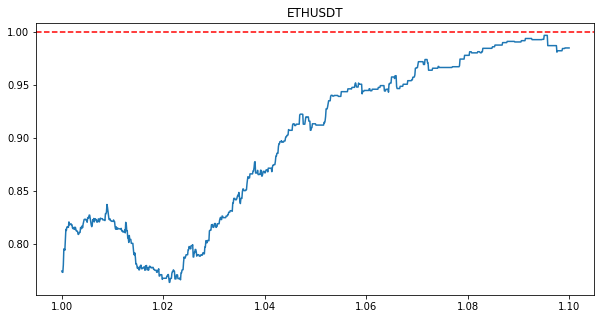

last_index : 25000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0300 - mean_absolute_error: 0.1318 - val_loss: 0.0135 - val_mean_absolute_error: 0.0911

Epoch 00001: val_loss improved from inf to 0.01348, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_25000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0825 - val_loss: 0.0099 - val_mean_absolute_error: 0.0780

Epoch 00002: val_loss improved from 0.01348 to 0.00992, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_25000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0089 - mean_absolute_error: 0.0727 - val_loss: 0.0078 - val_mean_absolute_error: 0.0683

Ep

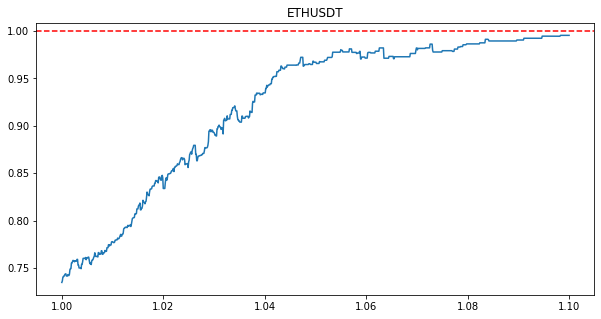

last_index : 26000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0697 - mean_absolute_error: 0.1877 - val_loss: 0.0181 - val_mean_absolute_error: 0.1063

Epoch 00001: val_loss improved from inf to 0.01814, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_26000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0915 - val_loss: 0.0121 - val_mean_absolute_error: 0.0847

Epoch 00002: val_loss improved from 0.01814 to 0.01214, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_26000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0795 - val_loss: 0.0098 - val_mean_absolute_error: 0.0750

Ep

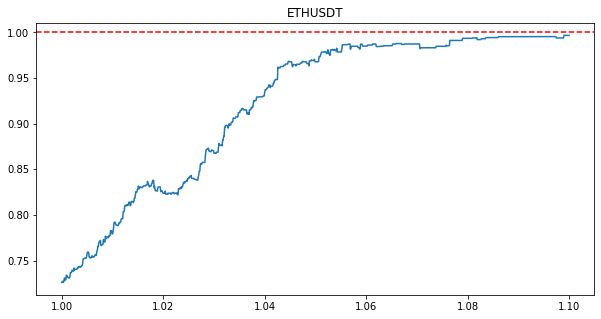

last_index : 27000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0901 - mean_absolute_error: 0.2126 - val_loss: 0.0199 - val_mean_absolute_error: 0.1123

Epoch 00001: val_loss improved from inf to 0.01988, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_27000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0152 - mean_absolute_error: 0.0962 - val_loss: 0.0134 - val_mean_absolute_error: 0.0896

Epoch 00002: val_loss improved from 0.01988 to 0.01336, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_27000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0119 - mean_absolute_error: 0.0840 - val_loss: 0.0114 - val_mean_absolute_error: 0.0823

Ep

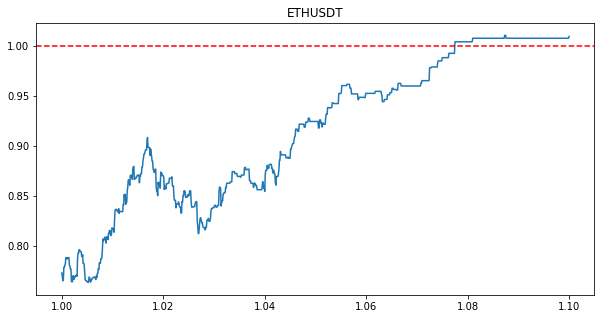

last_index : 28000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.1096 - mean_absolute_error: 0.2321 - val_loss: 0.0195 - val_mean_absolute_error: 0.1110

Epoch 00001: val_loss improved from inf to 0.01948, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_28000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0170 - mean_absolute_error: 0.1025 - val_loss: 0.0125 - val_mean_absolute_error: 0.0884

Epoch 00002: val_loss improved from 0.01948 to 0.01246, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_28000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0123 - mean_absolute_error: 0.0861 - val_loss: 0.0099 - val_mean_absolute_error: 0.0778

Ep

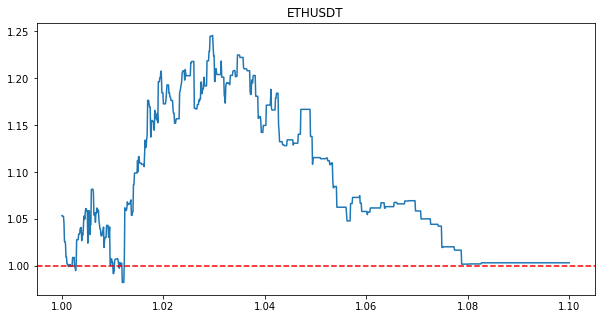

last_index : 29000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.1618 - mean_absolute_error: 0.2694 - val_loss: 0.0212 - val_mean_absolute_error: 0.1173

Epoch 00001: val_loss improved from inf to 0.02120, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_29000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0177 - mean_absolute_error: 0.1047 - val_loss: 0.0120 - val_mean_absolute_error: 0.0872

Epoch 00002: val_loss improved from 0.02120 to 0.01200, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_29000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0133 - mean_absolute_error: 0.0906 - val_loss: 0.0096 - val_mean_absolute_error: 0.0776

Ep

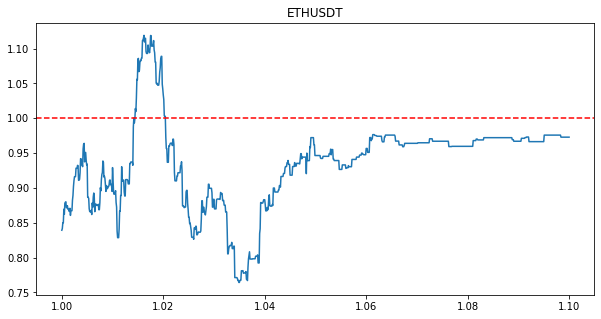

last_index : 30000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.1422 - mean_absolute_error: 0.2525 - val_loss: 0.0197 - val_mean_absolute_error: 0.1105

Epoch 00001: val_loss improved from inf to 0.01973, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_30000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0188 - mean_absolute_error: 0.1085 - val_loss: 0.0127 - val_mean_absolute_error: 0.0885

Epoch 00002: val_loss improved from 0.01973 to 0.01267, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_30000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0900 - val_loss: 0.0100 - val_mean_absolute_error: 0.0789

Ep

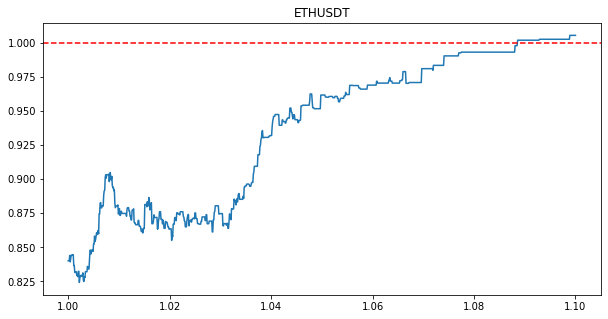

last_index : 31000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0697 - mean_absolute_error: 0.1866 - val_loss: 0.0149 - val_mean_absolute_error: 0.0963

Epoch 00001: val_loss improved from inf to 0.01490, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_31000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0127 - mean_absolute_error: 0.0888 - val_loss: 0.0106 - val_mean_absolute_error: 0.0803

Epoch 00002: val_loss improved from 0.01490 to 0.01065, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_31000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0096 - mean_absolute_error: 0.0760 - val_loss: 0.0086 - val_mean_absolute_error: 0.0716

Ep

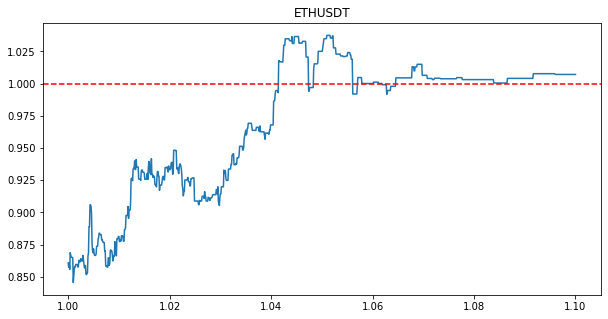

last_index : 32000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0715 - mean_absolute_error: 0.1867 - val_loss: 0.0172 - val_mean_absolute_error: 0.1035

Epoch 00001: val_loss improved from inf to 0.01721, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_32000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0141 - mean_absolute_error: 0.0933 - val_loss: 0.0123 - val_mean_absolute_error: 0.0872

Epoch 00002: val_loss improved from 0.01721 to 0.01229, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_32000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0808 - val_loss: 0.0102 - val_mean_absolute_error: 0.0783

Ep

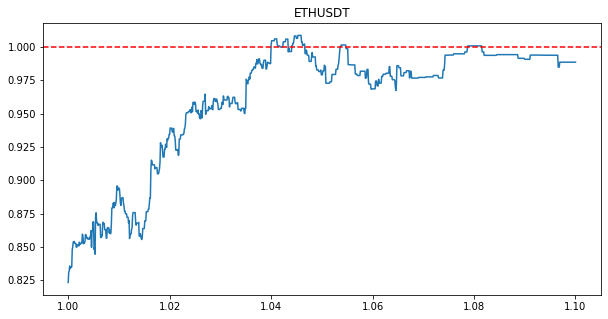

last_index : 33000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0893 - mean_absolute_error: 0.2104 - val_loss: 0.0141 - val_mean_absolute_error: 0.0934

Epoch 00001: val_loss improved from inf to 0.01408, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_33000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0126 - mean_absolute_error: 0.0873 - val_loss: 0.0097 - val_mean_absolute_error: 0.0764

Epoch 00002: val_loss improved from 0.01408 to 0.00972, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_33000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0753 - val_loss: 0.0082 - val_mean_absolute_error: 0.0701

Ep

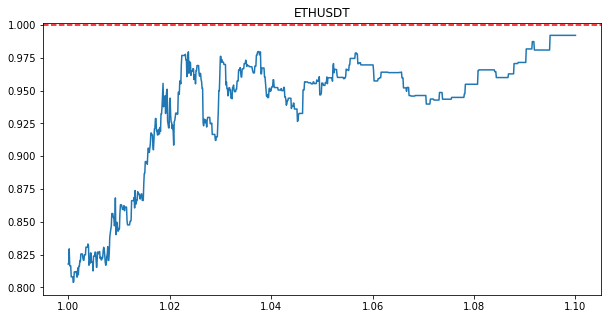

last_index : 34000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.2640 - mean_absolute_error: 0.3376 - val_loss: 0.0236 - val_mean_absolute_error: 0.1227

Epoch 00001: val_loss improved from inf to 0.02356, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_34000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0213 - mean_absolute_error: 0.1153 - val_loss: 0.0166 - val_mean_absolute_error: 0.1016

Epoch 00002: val_loss improved from 0.02356 to 0.01662, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_34000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0160 - mean_absolute_error: 0.1000 - val_loss: 0.0133 - val_mean_absolute_error: 0.0903

Ep

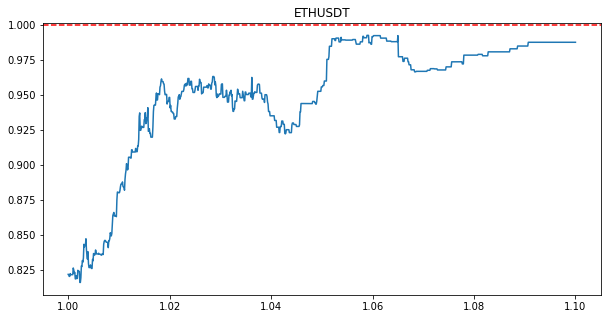

last_index : 35000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0642 - mean_absolute_error: 0.1815 - val_loss: 0.0187 - val_mean_absolute_error: 0.1093

Epoch 00001: val_loss improved from inf to 0.01870, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_35000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0147 - mean_absolute_error: 0.0961 - val_loss: 0.0134 - val_mean_absolute_error: 0.0924

Epoch 00002: val_loss improved from 0.01870 to 0.01343, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_35000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0112 - mean_absolute_error: 0.0836 - val_loss: 0.0108 - val_mean_absolute_error: 0.0824

Ep

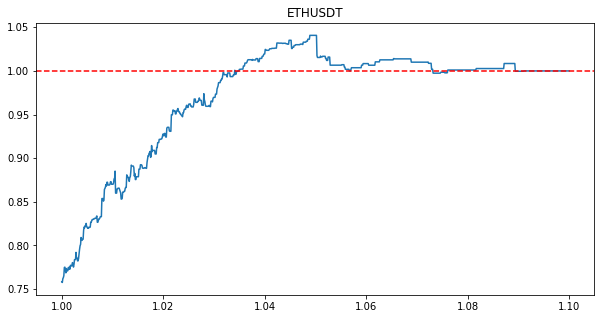

last_index : 36000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0711 - mean_absolute_error: 0.1918 - val_loss: 0.0177 - val_mean_absolute_error: 0.1059

Epoch 00001: val_loss improved from inf to 0.01773, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_36000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0129 - mean_absolute_error: 0.0890 - val_loss: 0.0127 - val_mean_absolute_error: 0.0887

Epoch 00002: val_loss improved from 0.01773 to 0.01273, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_36000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0099 - mean_absolute_error: 0.0778 - val_loss: 0.0104 - val_mean_absolute_error: 0.0796

Ep

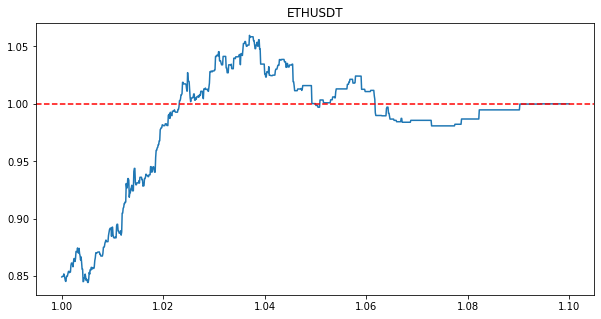

last_index : 37000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0731 - mean_absolute_error: 0.1927 - val_loss: 0.0180 - val_mean_absolute_error: 0.1044

Epoch 00001: val_loss improved from inf to 0.01797, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_37000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0136 - mean_absolute_error: 0.0906 - val_loss: 0.0111 - val_mean_absolute_error: 0.0828

Epoch 00002: val_loss improved from 0.01797 to 0.01113, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_37000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0799 - val_loss: 0.0092 - val_mean_absolute_error: 0.0752

Ep

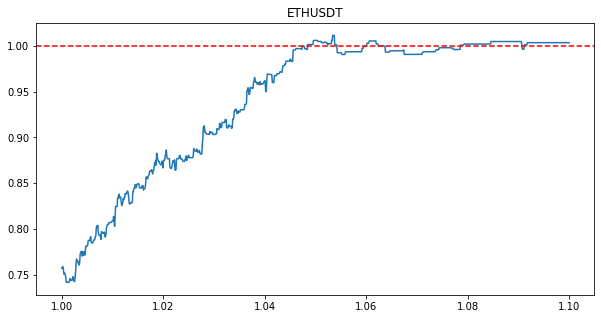

last_index : 38000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.1214 - mean_absolute_error: 0.2392 - val_loss: 0.0156 - val_mean_absolute_error: 0.0988

Epoch 00001: val_loss improved from inf to 0.01562, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_38000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0142 - mean_absolute_error: 0.0933 - val_loss: 0.0109 - val_mean_absolute_error: 0.0818

Epoch 00002: val_loss improved from 0.01562 to 0.01086, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_38000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0810 - val_loss: 0.0088 - val_mean_absolute_error: 0.0734

Ep

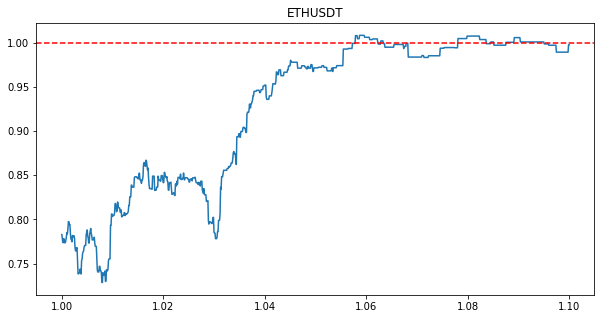

last_index : 39000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0325 - mean_absolute_error: 0.1322 - val_loss: 0.0099 - val_mean_absolute_error: 0.0778

Epoch 00001: val_loss improved from inf to 0.00994, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_39000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0099 - mean_absolute_error: 0.0772 - val_loss: 0.0069 - val_mean_absolute_error: 0.0646

Epoch 00002: val_loss improved from 0.00994 to 0.00687, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_39000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0687 - val_loss: 0.0058 - val_mean_absolute_error: 0.0597

Ep

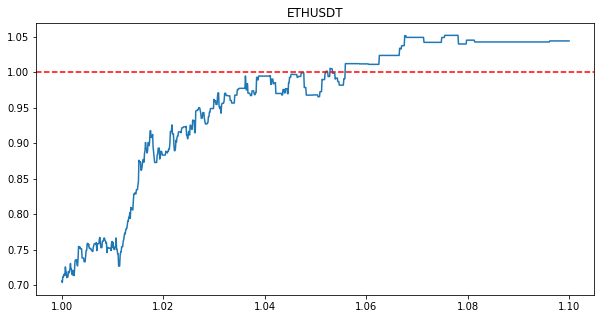

last_index : 40000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0926 - mean_absolute_error: 0.2108 - val_loss: 0.0153 - val_mean_absolute_error: 0.0989

Epoch 00001: val_loss improved from inf to 0.01534, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_40000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0924 - val_loss: 0.0105 - val_mean_absolute_error: 0.0810

Epoch 00002: val_loss improved from 0.01534 to 0.01055, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_15_1000_40000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_absolute_error: 0.0790 - val_loss: 0.0082 - val_mean_absolute_error: 0.0704

Ep

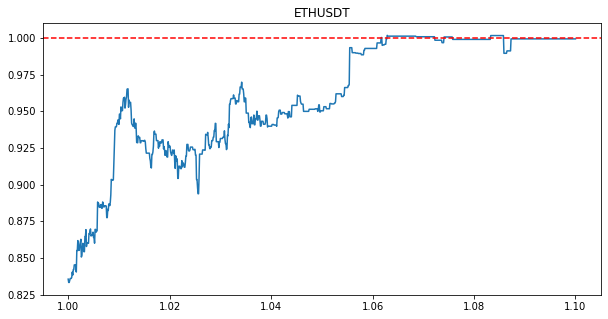

last_index : 41000


In [18]:
#         1. data slicing      #
tvt_size = 10000
shift_size = int(tvt_size * 0.1)
shift_i = 0

#         2. calc, iteration number     #
# data_len = len(data_x)


while 1:

  # if shift_i == 1:
  #   pass
  # else:
  #   shift_i += 1
  #   continue

  last_index = tvt_size + shift_size * shift_i
  print("last_index :", last_index)
  # print("last_index :", last_index)

  slice_x = data_x[shift_size * shift_i :last_index]
  
  #   reshape to 3d   #
  slice_x = slice_x.reshape(-1, slice_x.shape[1], slice_x.shape[2], 1)

  slice_labels = data_labels[shift_size * shift_i :last_index].reshape(-1, 1)

  if last_index > len(data_x):
    break

  else:
    shift_i += 1


  train_x = slice_x[:int(tvt_size * 0.7)]
  val_x = slice_x[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_x = slice_x[int(tvt_size * 0.9):]

  print("len(train_x) :", len(train_x))
  print("len(val_x) :", len(val_x))
  print("len(test_x) :", len(test_x))

  train_labels = slice_labels[:int(tvt_size * 0.7)]
  val_labels = slice_labels[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_labels = slice_labels[int(tvt_size * 0.9):]

  # sorted_pr = sorted(slice_labels, reverse=True)
  # pct = 0.28
  # len_pct = int(len(slice_labels) * pct)
  # pr_thresh = sorted_pr[len_pct]
  # print("pr_thresh :", pr_thresh)

  # pr_thresh = 1

  # train_y = np.where(train_labels > pr_thresh, 1, 0)
  # val_y = np.where(val_labels > pr_thresh, 1, 0)
  # test_y = np.where(test_labels > pr_thresh, 1, 0)

  train_y = train_labels
  val_y = val_labels
  test_y = test_labels
  
  from tensorflow.keras import utils

  # train_y_ohe = utils.to_categorical(train_y, 2)
  # val_y_ohe = utils.to_categorical(val_y, 2)
  # test_y_ohe = utils.to_categorical(test_y, 2)

  # train_y = train_labels[:, :, [target_label_index]]
  # val_y = val_labels[:, :, [target_label_index]]
  # test_y = test_labels[:, :, [target_label_index]]

  # print("train_labels.shape :", train_labels.shape)
  print("train_x.shape :", train_x.shape)
  print("train_y.shape :", train_y.shape)
  print()

  # from sklearn.utils import class_weight

  # label = train_y.reshape(-1, )
  # class_weights = class_weight.compute_class_weight('balanced', 
  #                                                     classes=np.unique(label),
  #                                                     y=label)
  # class_weights = dict(enumerate(class_weights))
  # print('class_weights :', class_weights)

  from tensorflow.keras.preprocessing.image import ImageDataGenerator 

  datagen = ImageDataGenerator( 
      # rotation_range = 45,
      # zoom_range = 0.5,
      # shear_range = 0.5,
      # horizontal_flip = True,
      # vertical_flip = True,
      # width_shift_range=0.5,
      # height_shift_range=0.5,
      # fill_mode = 'nearest'
      )

  valgen = ImageDataGenerator( 
      )

  datagen.fit(train_x)
  valgen.fit(val_x)
  batch_size = 128

  train_flow = datagen.flow(train_x, train_y, batch_size=batch_size) 
  val_flow = valgen.flow(val_x, val_y, batch_size=batch_size) 
  
  # train_flow = datagen.flow(train_x, train_y_ohe, batch_size=batch_size) 
  # val_flow = valgen.flow(val_x, val_y_ohe, batch_size=batch_size) 



  #         train         #
  pair_name = key.split(".")[0].split(" ")[1]

  # model_name = 'inner_tick_cnn_lscalemm_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, last_index)
  # model_name = 'inner_tick_cnn_lscalemm_postfee_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, last_index)
  # model_name = 'inner_tick_cnn_lscalemm_postfee_pct_%s_%s_%s_%s_%s.h5' % (pct* 1000, pair_name, input_size, label_size, last_index)
  model_name = 'inner_tick_cnnreg_lscalemm_prefee_gpu_%s_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, shift_size, last_index)
  # break

  #         train / test      #
  model = cnn2d_model(train_x.shape[1:])
  history = compile_and_fit(model, model_name, train_flow, val_flow)
  # history = compile_and_fit(model, model_name, train_flow, val_flow, class_weight=class_weights)
  
  # break
  model = tf.keras.models.load_model(ckpt_path + model_name)

  test_result = model.predict(test_x)
  print('test_result.shape :', test_result.shape)
  # print('pr_val.shape :', pr_val.shape)

  # y_score = test_result[:, [1]]
  y_score = test_result[:, [0]]
  print('test_y[:5] :', test_y.reshape(-1,)[:5])
  # print('np.unique(test_y) :', np.unique(test_y, return_counts=True))
  print('y_score[:5] :', y_score[:5])
  # print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

  print('test_y.shape :', test_y.shape)
  print('y_score.shape :', y_score.shape)

  print('len(test_y) :', len(test_y))

  from sklearn.metrics import precision_recall_curve

  #     precision recall curve   #
  # precision, recall, threshold = precision_recall_curve(test_y, y_score)
  # precision, recall = precision[:-1], recall[:-1]

  # plt.plot(threshold, precision, label='precision')
  # plt.plot(threshold, recall, label='recall')
  # plt.legend()
  # plt.title('precision recall')
  # plt.show()
  # print(y_pred)


  lvrg = 1
  fee = 0.0006


  # threshold = [0.65]
  # print('threshold :', threshold)
  # break

  acc_pr_bythr = []
  new_thresh = []

  threshold = np.arange(1, 1.1, 0.0001)

  for thresh in threshold:
    
    # if thresh < 0.5:
    #     continue

    y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
    # print('y_pred.shape :', y_pred.shape)
    # print('y_pred :', y_pred)

    #     compare precision     #

    # print('precision :', precision_score(test_y, y_pred))
    # print('recall :', recall_score(test_y, y_pred))
    # print()

    # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
    # print('np.isnan(np.sum(test_y)) :', np.isnan(np.sum(test_y)))

    # # plot_confusion_matrix(best_model, x_test, test_y, normalize=None)
    # # plt.show()  
    # print()

    # from sklearn.metrics import confusion_matrix

    # #     check win-ratio improvement     #
    # cmat = confusion_matrix(test_y, y_pred)
    # # print(cmat)
    # # print(np.sum(cmat, axis=1))
    

    # org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
    # ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
    # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

    test_size = len(test_y)
    test_pr_list = test_labels
    # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

    # print('pr_test.shape :', pr_test.shape)

    # print(y_pred)
    # print(test_pr_list)

    pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1)
    # print("pred_pr_list[:10] :", pred_pr_list[:10])

    #       after fee adjustment    #
    # pred_pr_list = (pred_pr_list - 1 - fee) * lvrg + 1

    # pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
    # pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
    # print('pred_pr_list.shape :', pred_pr_list.shape)

    # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    #   print('thresh :', thresh)
      
    # if len(threshold) == 1:
  #   plt.figure(figsize=(10, 5))
  #   plt.subplot(121)
  #   plt.plot(np.cumprod(test_pr_list))
  #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # # plt.show()

  #   plt.subplot(122)
  #   plt.plot(np.cumprod(pred_pr_list))
  #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
  #   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
  #   plt.show()


    acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
    new_thresh.append(thresh)


  print('acc_pr_bythr :', acc_pr_bythr)

  plt.figure(figsize=(10, 5))
  # plt.subplot(121)
  # plt.plot(threshold, precision, label='precision')
  # plt.plot(threshold, recall, label='recall')
  # plt.legend()
  # plt.title('precision recall')
  # plt.show()

  # plt.subplot(122)
  plt.plot(new_thresh, acc_pr_bythr)
  plt.axhline(1, linestyle='--', color='r')
  plt.title(pair_name)
  plt.show()



#### get_best_thr function

In [ ]:
def get_best_thr(thresh_list, test_x, pred_y, lvrg=5, plotting=False, pr_plot=False):
  
  thresh_pr_list = []
  fee = 0.0006

   
  # # plotting = True
  # plotting = False

  # # pr_plot = True
  # pr_plot = False

  #       find best thresh        #
  for thresh in tqdm(thresh_list):

    pr_list = []
    i = 0
    while 1:
    # for i in range(len(test_y)):

      try:
        input = test_x[i, :, target_label_index]
      except:
        input = test_x[i, :, 0]


      label = test_y[i]
      pred = pred_y[i]

      # print("label.shape :", label.shape)
      # print("len(label) :", len(label))
      # print("shift_size :", shift_size)
      # break

      # input_close = test_slice_close_x[i, :, :]
      # # input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
      # close = test_slice_label_close_x[i, :, :]

      #     find highest / lowest arg     #
      # high_arg = np.argmax(pred)
      # low_arg = np.argmin(pred)

      #     we always sell high, buy low    #
      label_pr = label[-1]
      pred_pr = pred[-1]

      if plotting:

        # if pred_pr > thresh:

          # plt.subplot(211)
          # plt.plot(np.arange(len(input_close)), input_close)
          # plt.plot(np.arange(len(close)) + input_size, close)
          # plt.axvline(high_arg + input_size)
          # plt.axvline(low_arg + input_size)

          # plt.subplot(212)
          # plt.plot(np.arange(len(input)), input,
          #         label='Inputs', marker='.', zorder=-10)    
          # plt.scatter(np.arange(len(label)), label,
          #           edgecolors='k', label='Labels', c='#2ca02c', s=64)
          # plt.scatter(np.arange(len(pred)), pred,
          #             marker='X', edgecolors='k', label='Predictions',
          #             c='#ff7f0e', s=64)

          plt.plot(label)
          plt.plot(pred)
          
          plt.axhline(thresh)
          # plt.plot(pred)
          # plt.plot(label)
          # plt.axvline(high_arg + input_size)
          # plt.axvline(low_arg + input_size)


          # plt.suptitle("%.3f" % pr)
          plt.show()

      calc_label_pr = (label_pr - fee) * lvrg + 1
      calc_pred_pr = (pred_pr - fee) * lvrg + 1

      if calc_pred_pr > thresh + 1:
        pr_list.append(calc_label_pr)
        # print("label_pr :", label_pr)

      #     i should moved to end of trading index    #
      #     long    #
      # if high_arg > low_arg:
      #   i += high_arg
      # else:
      #   i += low_arg

      i += 1

      # print("i :", i)

      if i >= len(test_y):
        break
      # else:
      #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

      #     shift, if trade complished    #

    if pr_plot:
      np_pr_list = np.array(pr_list)
      wr = len(np_pr_list[np_pr_list > 1]) / len(np_pr_list[np_pr_list != 1]) 

      plt.plot(np.cumprod(pr_list))
      plt.title("%s\nwr : %.3f" % (key, wr))
      plt.show()

    if len(pr_list) == 0:
      thresh_pr_list.append(1)
    else:
      thresh_pr_list.append(np.cumprod(pr_list)[-1])

  best_thr = thresh_list[np.argmax(thresh_pr_list)]

  if len(thresh_list) != 1:
    plt.plot(thresh_list, thresh_pr_list)
    plt.axvline(best_thr)
    plt.title(best_thr)
    plt.show()

  return best_thr

#### find best_thr

Text(0.5, 1.0, '0.013460000000000034')

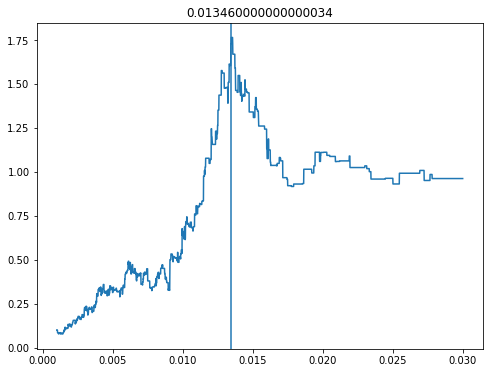

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
test_result = model.predict(test_x)

pred_y = test_result
# pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
# lvrg = 1
thresh_pr_list = []

# plotting = True
plotting = False

# pr_plot = True
pr_plot = False

thresh = 0.015
# thresh = -0.001

thresh_list = np.arange(0.001, 0.03, 1e-5)


#       find best thresh        #
for thresh in tqdm(thresh_list):

  pr_list = []
  i = 0
  while 1:
  # for i in range(len(test_y)):

    try:
      input = test_x[i, :, target_label_index]
    except:
      input = test_x[i, :, 0]


    label = test_y[i]
    pred = pred_y[i]

    # print("label.shape :", label.shape)
    # print("len(label) :", len(label))
    # print("shift_size :", shift_size)
    # break

    # input_close = test_slice_close_x[i, :, :]
    # # input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
    # close = test_slice_label_close_x[i, :, :]

    #     find highest / lowest arg     #
    # high_arg = np.argmax(pred)
    # low_arg = np.argmin(pred)

    #     we always sell high, buy low    #
    label_pr = label[-1]
    pred_pr = pred[-1]

    if plotting:

      # if pred_pr > thresh:

        # plt.subplot(211)
        # plt.plot(np.arange(len(input_close)), input_close)
        # plt.plot(np.arange(len(close)) + input_size, close)
        # plt.axvline(high_arg + input_size)
        # plt.axvline(low_arg + input_size)

        # plt.subplot(212)
        # plt.plot(np.arange(len(input)), input,
        #         label='Inputs', marker='.', zorder=-10)    
        # plt.scatter(np.arange(len(label)), label,
        #           edgecolors='k', label='Labels', c='#2ca02c', s=64)
        # plt.scatter(np.arange(len(pred)), pred,
        #             marker='X', edgecolors='k', label='Predictions',
        #             c='#ff7f0e', s=64)

        plt.plot(label)
        plt.plot(pred)
        
        plt.axhline(thresh)
        # plt.plot(pred)
        # plt.plot(label)
        # plt.axvline(high_arg + input_size)
        # plt.axvline(low_arg + input_size)


        # plt.suptitle("%.3f" % pr)
        plt.show()

    calc_label_pr = (label_pr - fee) * lvrg + 1
    calc_pred_pr = (pred_pr - fee) * lvrg + 1

    if calc_pred_pr > thresh + 1:
      pr_list.append(calc_label_pr)
      # print("label_pr :", label_pr)

    #     i should moved to end of trading index    #
    #     long    #
    # if high_arg > low_arg:
    #   i += high_arg
    # else:
    #   i += low_arg

    i += 1

    # print("i :", i)

    if i >= len(test_y):
      break
    # else:
    #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

    #     shift, if trade complished    #

  if pr_plot:
    np_pr_list = np.array(pr_list)
    wr = len(np_pr_list[np_pr_list > 1]) / len(np_pr_list[np_pr_list != 1]) 

    plt.plot(np.cumprod(pr_list))
    plt.title("%s\nwr : %.3f" % (key, wr))
    plt.show()

  thresh_pr_list.append(np.cumprod(pr_list)[-1])

best_thr = thresh_list[np.argmax(thresh_pr_list)]
plt.plot(thresh_list, thresh_pr_list)
plt.axvline(best_thr)
plt.title(best_thr)

#### val_thr on test_set

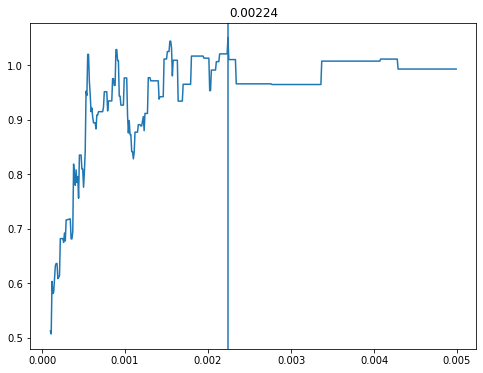

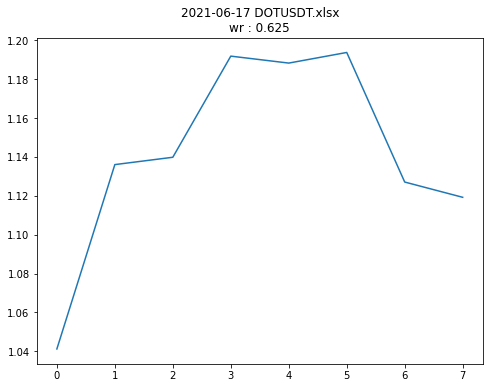

0.00224

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
val_result = model.predict(val_x)
test_result = model.predict(test_x)

# pred_y = test_result
# pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
# lvrg = 1
thresh_pr_list = []


# thresh = 0.015
# thresh = -0.001

thresh_list = np.arange(0.0001, 0.005, 1e-5)

val_best_thr = get_best_thr(thresh_list, val_x, val_result)

get_best_thr([val_best_thr], test_x, test_result, pr_plot=True)


#### train_thresh

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
train_result = model.predict(train_x)
train_best_thr = get_best_thr(thresh_list, train_x, train_result)
